In [13]:
import numpy as np
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '1'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [15]:
actions = [
    'ice',
    'hot',
    'americano',
    'card'
]

data = np.concatenate([
    np.load('./dataset/seq_ice_1713252319.npy'),
    np.load('./dataset/seq_hot_1713252319.npy'),
    np.load('./dataset/seq_americano_1713252319.npy'),
    np.load('./dataset/seq_card_1713252319.npy')
], axis=0)

data.shape

(2594, 30, 100)

In [16]:
x_data = data[:, :, :-1]
labels = data[:, 0, -1]

print(x_data.shape)
print(labels.shape)

(2594, 30, 99)
(2594,)


In [17]:
from tensorflow.keras.utils import to_categorical

y_data = to_categorical(labels, num_classes=len(actions))
y_data.shape

(2594, 4)

In [18]:
from sklearn.model_selection import train_test_split

x_data = x_data.astype(np.float32)
y_data = y_data.astype(np.float32)

x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.1, random_state=2021)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(2334, 30, 99) (2334, 4)
(260, 30, 99) (260, 4)


In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential([
    LSTM(64, activation='relu', input_shape=x_train.shape[1:3]),
    Dense(32, activation='relu'),
    Dense(len(actions), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

c:\Users\GJ\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 64)             │        41,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,196 (172.64 KB)

 Trainable params: 44,196 (172.64 KB)

 Non-trainable params: 0 (0.00 B)

In [20]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

history = model.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=200,
    callbacks=[
        ModelCheckpoint('models/model.keras', monitor='val_acc', verbose=1, save_best_only=True, mode='auto'),
        ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=50, verbose=1, mode='auto')
    ]
)

Epoch 1/200
69/73 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.2429 - loss: 32.4984
Epoch 1: val_acc improved from -inf to 0.38462, saving model to models/model.keras
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - acc: 0.2449 - loss: 32.0614 - val_acc: 0.3846 - val_loss: 18.2641 - learning_rate: 0.0010
Epoch 2/200
68/73 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.4299 - loss: 10.3447
Epoch 2: val_acc improved from 0.38462 to 0.39231, saving model to models/model.keras
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - acc: 0.4325 - loss: 10.1572 - val_acc: 0.3923 - val_loss: 9.8244 - learning_rate: 0.0010
Epoch 3/200
68/73 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.4776 - loss: 9.1492
Epoch 3: val_acc improved from 0.39231 to 0.46538, saving model to models/model.keras
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - acc: 0.4785 - loss: 9.0123 - val_acc: 0.4654 - val_loss: 4.7248 - learning_rate: 0.0010
Epoch 4/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - acc: 0.5163 - loss: 4.5278
Epoch 4: val_acc improved from 0

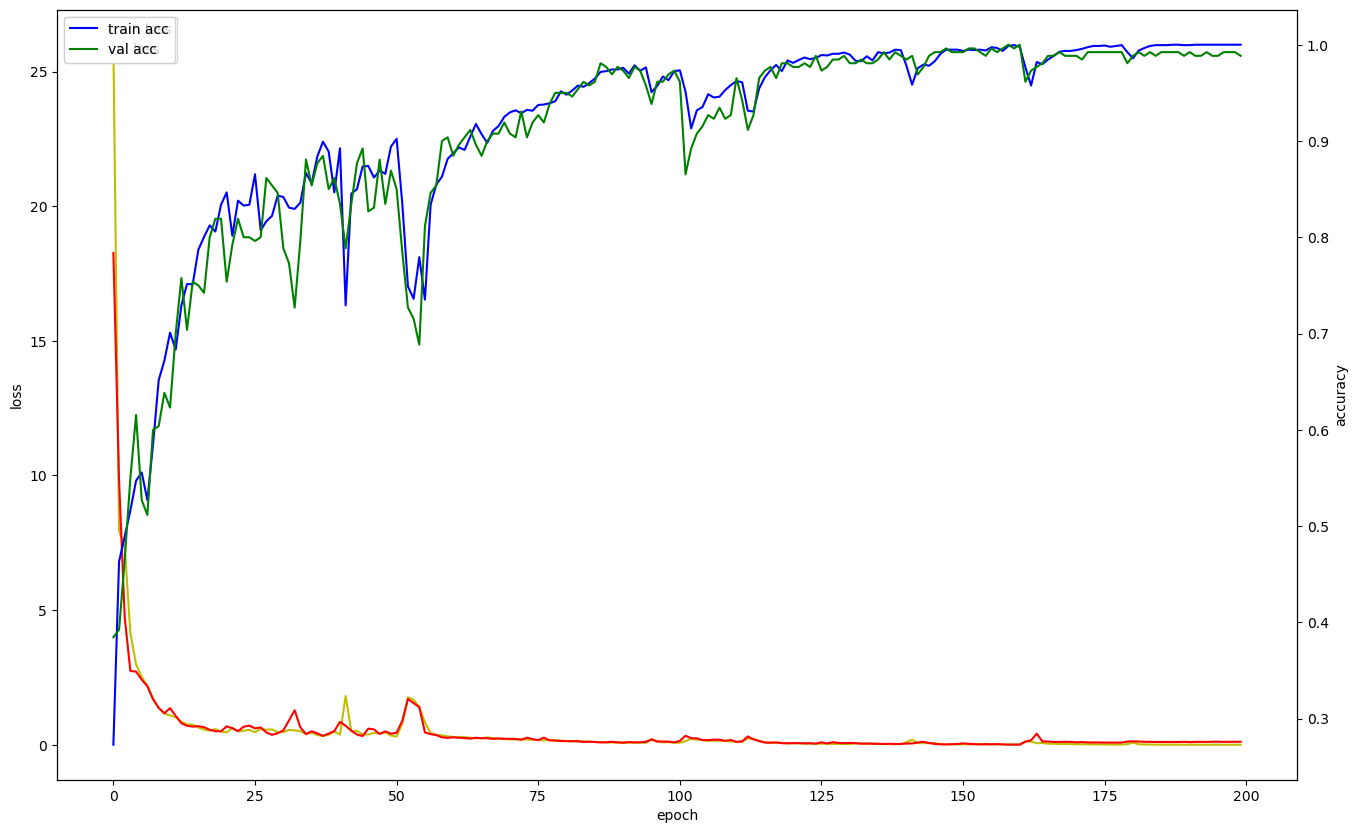

In [21]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots(figsize=(16, 10))
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(history.history['acc'], 'b', label='train acc')
acc_ax.plot(history.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper left')

plt.show()

In [22]:
from sklearn.metrics import multilabel_confusion_matrix
from tensorflow.keras.models import load_model

model = load_model('models/model.keras')

y_pred = model.predict(x_val)

multilabel_confusion_matrix(np.argmax(y_val, axis=1), np.argmax(y_pred, axis=1))

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


array([[[189,   0],
        [  0,  71]],

       [[208,   0],
        [  0,  52]],

       [[184,   0],
        [  0,  76]],

       [[199,   0],
        [  0,  61]]], dtype=int64)